# DengAI: Predicting Disease Spread
***
As part of the __[Predict the Next Epidemic Initiative](https://obamawhitehouse.archives.gov/blog/2015/06/05/back-future-using-historical-dengue-data-predict-next-epidemic)__ __[Driven Data](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)__ is running a competition requiring participants to build a predictive model for dengue fever. Dengue fever is endemic in the tropics and subtropics and there has been a rising number of cases in recent years. There are two and a half billion people in world who are vulnerable to dengue fever and an estimated fifty to a hundred people are infected yearly __[(1)](https://www.cdc.gov/dengue/epidemiology/index.html)__. As the climate grows warmer outbreak of dengue is likely to be seen in more places and could become a bigger global health crisis. It is necessary to try and create models to predict future outbreaks so they can be dealt with proactively.

In [60]:
#load libraries
%matplotlib inline 

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [61]:
x = pd.read_csv('dengue_features_train.csv')
y = pd.read_csv('dengue_labels_train.csv')
xcomp_test = pd.read_csv('dengue_features_test.csv')

In [62]:
df = pd.merge(x, y, on=['city', 'year', 'weekofyear'])
df = df.dropna(axis=0)

Dengue fever is spread by mosquitoes and the data we’ve been given for our model is climate and vegetation data. The data is taken from four different datasets and contains twenty three variables including precipitation, dew point, and temperature. A more detailed breakdown of where the data is from and the variables included in the dataset can be found __[here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/)__. Let's start by taking a look at the distribution of the data. 

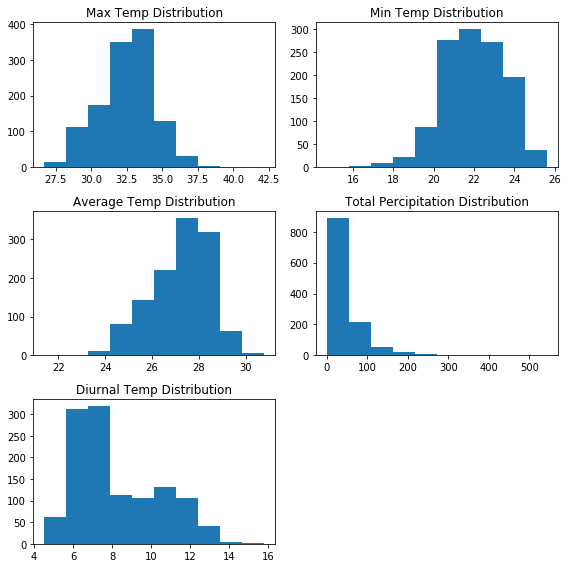

In [113]:
#NOAA's GHCN daily climate data distribution
plt.subplot(3, 2, 1)
plt.hist(df.station_max_temp_c)
plt.title('Max Temp Distribution')

plt.subplot(3, 2, 2)
plt.hist(df.station_min_temp_c)
plt.title('Min Temp Distribution')

plt.subplot(3, 2, 3)
plt.hist(df.station_avg_temp_c)
plt.title('Average Temp Distribution')

plt.subplot(3, 2, 4)
plt.hist(df.station_precip_mm)
plt.title('Total Percipitation Distribution')

plt.subplot(3, 2, 5)
plt.hist(df.station_diur_temp_rng_c)
plt.title('Diurnal Temp Distribution')

plt.rcParams['figure.figsize'] = [9, 9]
plt.tight_layout()

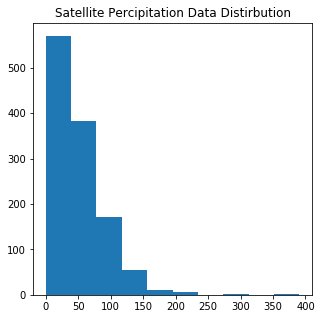

In [50]:
#PERSIANN satellite precipitation distribution
plt.hist(df.precipitation_amt_mm)
plt.title('Satellite Percipitation Data Distirbution')
plt.rcParams['figure.figsize'] = [5, 5]

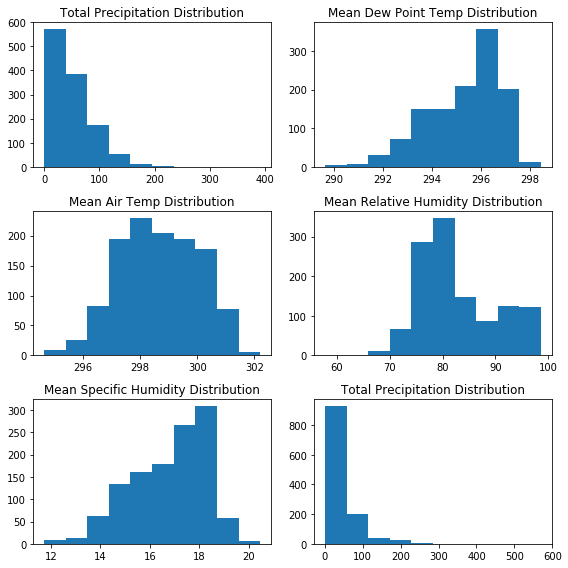

In [52]:
#NOAA's NCEP Climate Forecast System Reanalysis Distribution
plt.subplot(3, 2, 1)
plt.hist(df.reanalysis_sat_precip_amt_mm)
plt.title('Total Precipitation Distribution')

plt.subplot(3, 2, 2)
plt.hist(df.reanalysis_dew_point_temp_k)
plt.title('Mean Dew Point Temp Distribution')

plt.subplot(3, 2, 3)
plt.hist(df.reanalysis_air_temp_k)
plt.title('Mean Air Temp Distribution')

plt.subplot(3, 2, 4)
plt.hist(df.reanalysis_relative_humidity_percent)
plt.title('Mean Relative Humidity Distribution')

plt.subplot(3, 2, 5)
plt.hist(df.reanalysis_specific_humidity_g_per_kg)
plt.title('Mean Specific Humidity Distribution')

plt.subplot(3, 2, 6)
plt.hist(df.reanalysis_precip_amt_kg_per_m2)
plt.title('Total Precipitation Distribution')

plt.rcParams['figure.figsize'] = [8, 8]
plt.tight_layout()

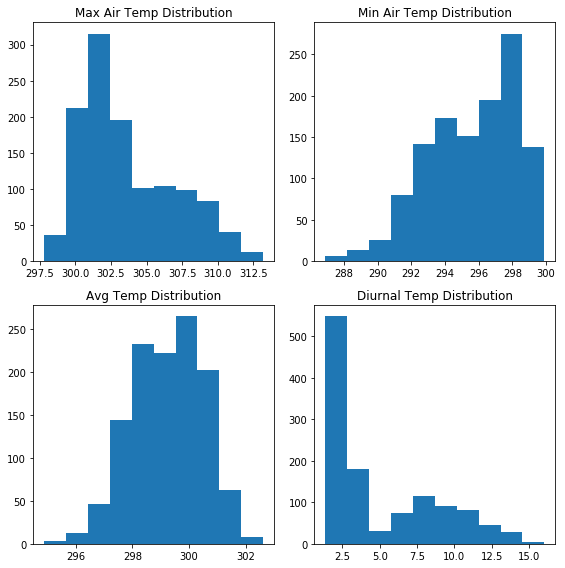

In [53]:
#NOAA's NCEP Climate Forecast System Reanalysis Distribution
plt.subplot(2, 2, 1)
plt.hist(df.reanalysis_max_air_temp_k)
plt.title('Max Air Temp Distribution')

plt.subplot(2, 2, 2)
plt.hist(df.reanalysis_min_air_temp_k)
plt.title('Min Air Temp Distribution')

plt.subplot(2, 2, 3)
plt.hist(df.reanalysis_avg_temp_k)
plt.title('Avg Temp Distribution')

plt.subplot(2, 2, 4)
plt.hist(df.reanalysis_tdtr_k)
plt.title('Diurnal Temp Distribution')

plt.rcParams['figure.figsize'] = [8, 8]
plt.tight_layout()

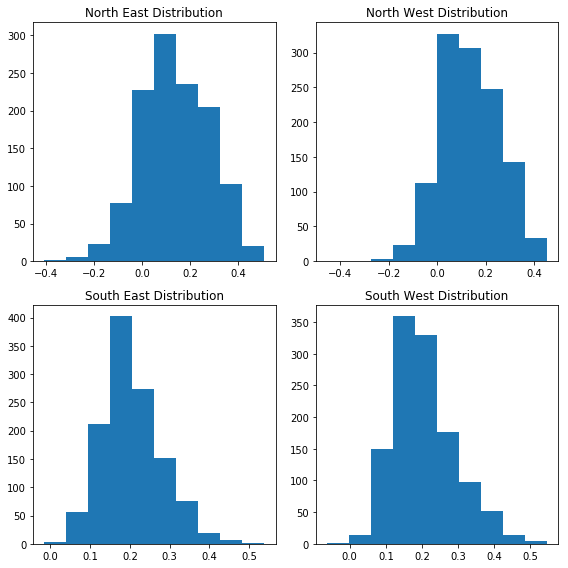

In [54]:
#Normalized Difference Vegetation Index Data Distribution
plt.subplot(2, 2, 1)
plt.hist(df.ndvi_ne)
plt.title('North East Distribution')

plt.subplot(2, 2, 2)
plt.hist(df.ndvi_nw)
plt.title('North West Distribution')

plt.subplot(2, 2, 3)
plt.hist(df.ndvi_se)
plt.title('South East Distribution')

plt.subplot(2, 2, 4)
plt.hist(df.ndvi_sw)
plt.title('South West Distribution')

plt.rcParams['figure.figsize'] = [8, 8]
plt.tight_layout()

We can see that some of our variables have skewed distributions like average temperature and total precipitation. We can keep in mind when doing our modeling. Let’s also look at the coefficient matrix for our variables to get a sense for which variables correlated to the total number of cases most.

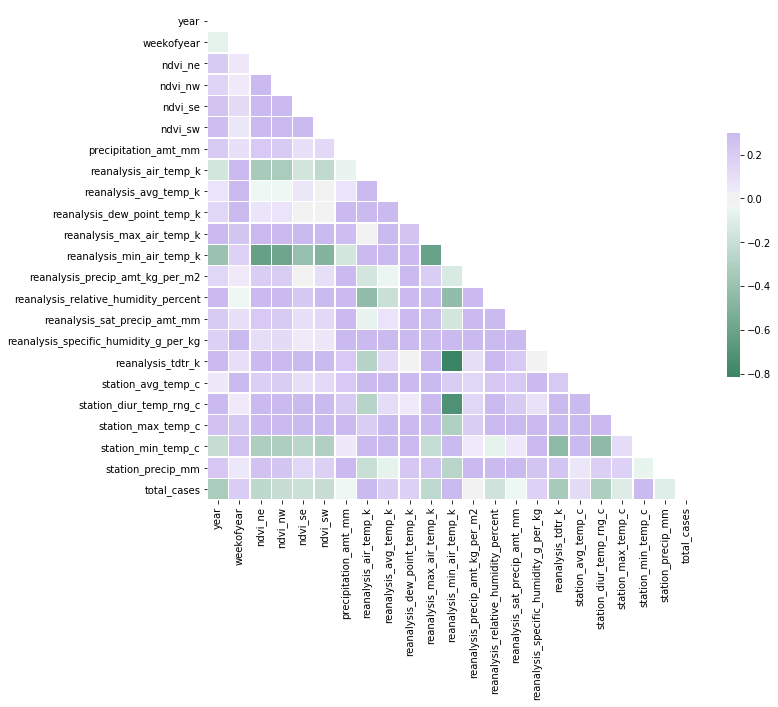

In [9]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(150, 275, as_cmap=True)

g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.rcParams['figure.figsize'] = [6, 6]

The five variables that seem to relate most to total_cases are station_min_temp_c, station_diur_temp_rng_c, reanalysis_air_temp_k, reanalysis_min_air_temp_k, and reanalysis_tdtr_k. Let’s create scatter plots of these variables versus total_cases to examine this more closely.

Text(0.5,1,'Min Temp vs Number of Cases')

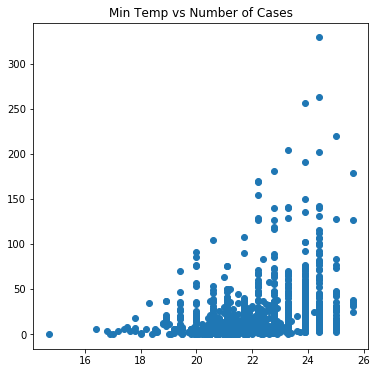

In [10]:
plt.scatter(df.station_min_temp_c, df.total_cases)
plt.title('Min Temp vs Number of Cases')

Text(0.5,1,'Diurnal Temp vs Number of Cases')

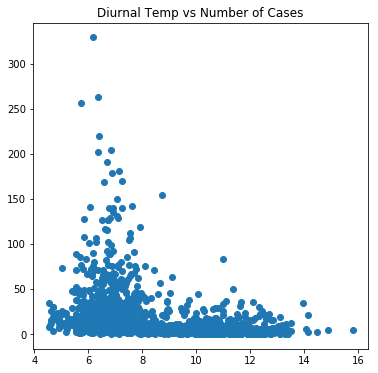

In [11]:
plt.scatter(df.station_diur_temp_rng_c, df.total_cases)
plt.title('Diurnal Temp vs Number of Cases')

Text(0.5,1,'Air Temp vs Number of Cases')

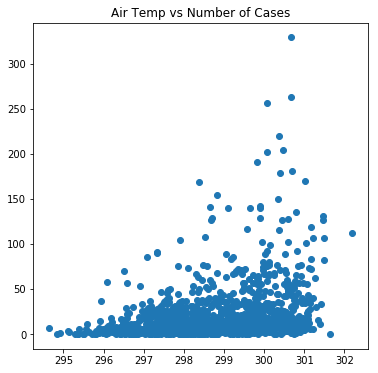

In [12]:
plt.scatter(df.reanalysis_air_temp_k, df.total_cases)
plt.title('Air Temp vs Number of Cases')

Text(0.5,1,' Min Air Temp vs Number of Cases')

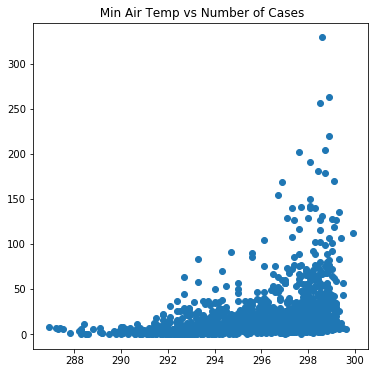

In [13]:
plt.scatter(df.reanalysis_min_air_temp_k, df.total_cases)
plt.title(' Min Air Temp vs Number of Cases')

Text(0.5,1,' Min Air Temp vs Number of Cases')

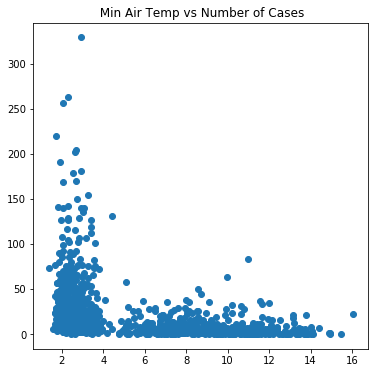

In [14]:
plt.scatter(df.reanalysis_tdtr_k, df.total_cases)
plt.title(' Min Air Temp vs Number of Cases')

We can see from the scatter plots above that the relationship between our dependant and independant variable are nonlinear. Because we're trying to predict a continuous variable we will be using regression. We can’t use linear regression so we’ll have to pick a modeling algorithm that can fit nonlinear data. An ensemble method might work best for our data according to __[this](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)__ cheat sheet from the sklearn documentation about choosing the right estimator. Let’s try using random forest regression to model our data.

In [64]:
df1 = df.drop(['city','week_start_date'], axis=1)
y1 = df.total_cases
df1 = df1.drop('total_cases', axis=1)

x_train, x_test, y_train, y_test = train_test_split(df1, y1, test_size=0.2)

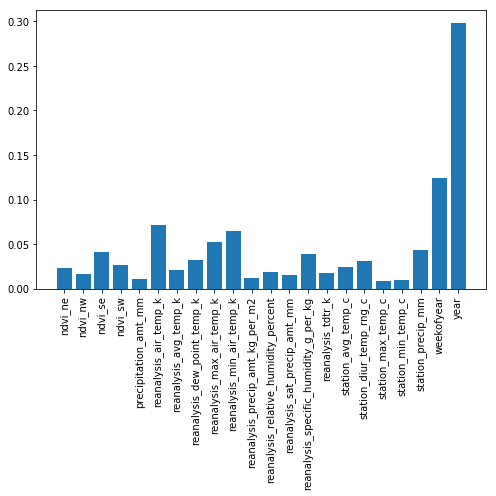

In [66]:
rfr = RandomForestRegressor()

m = rfr.fit(x_train, y_train)
p = rfr.predict(x_test)

feat = pd.DataFrame({'features': df1.columns, 'feature importance': rfr.feature_importances_})

plt.bar(feat['features'], feat['feature importance'])
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [7, 7]
plt.tight_layout()

Looking at the barplot above for feature importance shows that the largest amount of error is introduced into our model without year as a variable. The next most important feature also seems to be weekofyear. Let's take a look at the scatter plot for predicted values versus actual values to see how well our model performed.

Text(0,0.5,'Predicted Values')

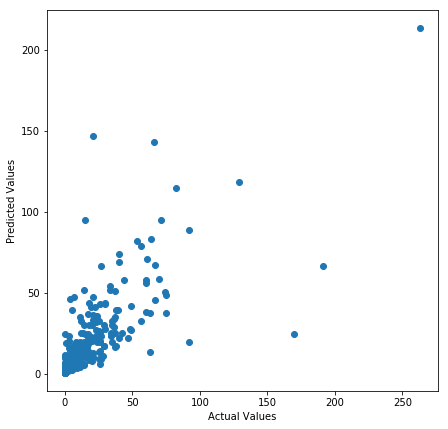

In [68]:
plt.scatter(y_test, p)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [69]:
print(m.score(x_test, y_test))

0.47549764343189715


We get a R-squared value of 0.475 which means our model explains about 48% of the variance in our data. To evaluate our model more completely let’s see what the average error was. 

In [70]:
errors = abs(p - y_test)
np.mean(errors)

11.56666666666667

The average error was almost 12 cases which is quite large when we keep in mind that the number of cases reported during most weeks were in the single digits. It isn’t useful to have a model that is making such large errors. Let's try to improve our model by hypertuning it.

In [101]:
from sklearn.model_selection import RandomizedSearchCV

x1_train, x1_test, y1_train, y1_test = train_test_split(df1, y1, test_size=0.2)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3)

rf_random.fit(x1_train, y1_train)
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

After running a random grid search we’ve gotten an output of ideal parameters for our model. Let’s pass these parameters to our random forest regressor to see if it improves our model.

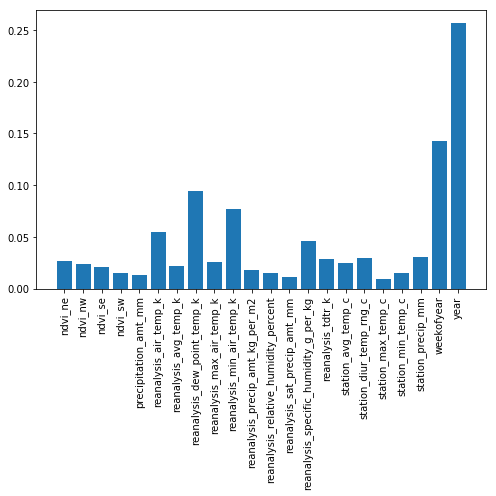

In [102]:
rfr2 = RandomForestRegressor(bootstrap= True,
                             max_depth= 60,
                             max_features= 'auto',
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             n_estimators= 200)

m1 = rfr2.fit(x1_train, y1_train)
p1 = rfr2.predict(x1_test)

feat1 = pd.DataFrame({'features': df1.columns, 'feature importance': rfr2.feature_importances_})

plt.bar(feat1['features'], feat1['feature importance'])
plt.xticks(rotation=90)
plt.tight_layout()

We can see that the bar plot for our feature importance looks quite similar to the previous one, with year and weekofyear being most important to our model. Let’s calculate the R-squared and average error for our second model.

Text(0,0.5,'Predicted Values')

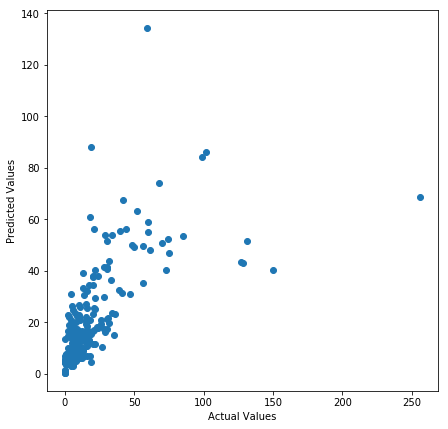

In [103]:
plt.scatter(y1_test, p1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [114]:
print(m1.score(x1_test, y1_test))

0.4518408565242631


In [104]:
errors = abs(p1 - y1_test)
np.mean(errors)

10.070958333333333

We can see that our second model doesn’t seem to improve that much on our first model. The R-squared is slightly less with our second model explaining 45% of the variance in our data. The average error is lower though as well with an average error of about 10. An average error of 10 cases is still a lot when the number of cases in a week are in the single digits. We can also try to improve our model by simplifying it. Using less variables means there’ll be less noise in our data. We’re going to use 'reanalysis_tdtr_k', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm', 'reanalysis_max_air_temp_k', 'reanalysis_relative_humidity_percent', 'year', and 'weekofyear' this time. Those are the variables that seem to have the highest amount of predictive value and correlation with the number of cases. 

In [90]:
cols = ['reanalysis_tdtr_k', 'reanalysis_min_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_sat_precip_amt_mm', 
        'reanalysis_max_air_temp_k', 'reanalysis_relative_humidity_percent', 'year', 'weekofyear', 'total_cases']

dflite = df.loc[:, cols]

y = dflite.total_cases
dflite = dflite.drop('total_cases', axis=1)

x2_train, x2_test, y2_train, y2_test = train_test_split(dflite, y, test_size=0.2)

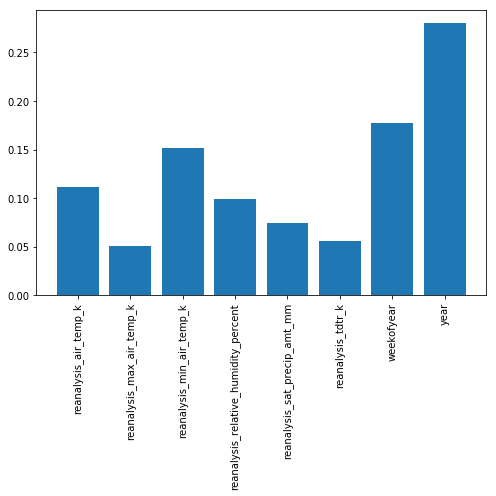

In [91]:
rfr1 = RandomForestRegressor()

m2 = rfr1.fit(x2_train, y2_train)
p2 = rfr1.predict(x2_test)

feat2 = pd.DataFrame({'features': dflite.columns, 'feature importance': rfr1.feature_importances_})

plt.bar(feat2['features'], feat2['feature importance'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.rcParams['figure.figsize'] = [7, 7]

Feature importance seems to be about the same for our variables in our third model. Let’s take a look at the scatter plot, R-squared, and average error. 

Text(0,0.5,'Predicted Values')

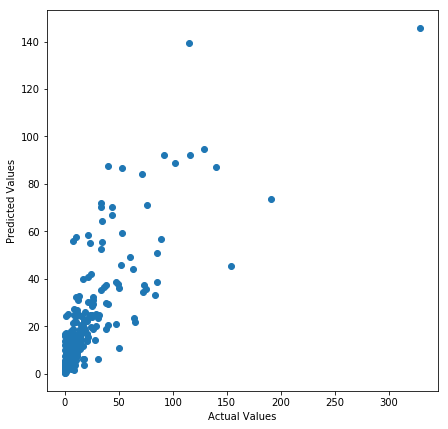

In [92]:
plt.scatter(y2_test, p2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [93]:
print(m2.score(x2_test, y2_test))

0.6082606170811379


In [95]:
errors = abs(p2 - y2_test)
np.mean(errors)

11.079166666666667

We can see that the R-squared has gone up and around 60% of the variation in the data can be explained by our model. However there’s been no significant change in the average error with our average error being 11. This most likely means that our algorithm is overfitting now that we have eliminated the other variables. Let's try to rerun our simpler model with the parameters for our third model. 

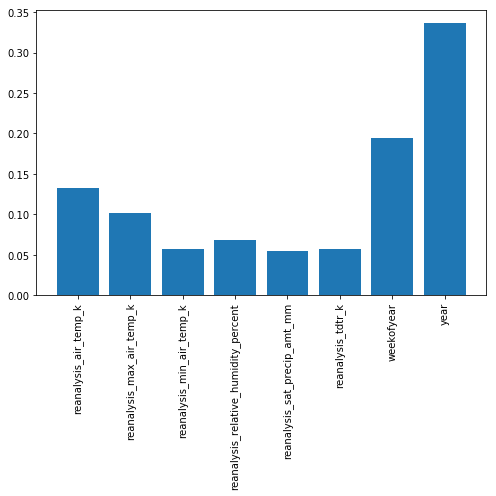

In [106]:
x3_train, x3_test, y3_train, y3_test = train_test_split(dflite, y, test_size=0.2)

rfr3 = RandomForestRegressor(bootstrap= True,
                             max_depth= 60,
                             max_features= 'auto',
                             min_samples_leaf= 1,
                             min_samples_split= 2,
                             n_estimators= 200)

m3 = rfr3.fit(x3_train, y3_train)
p3 = rfr3.predict(x3_test)

feat2 = pd.DataFrame({'features': dflite.columns, 'feature importance': rfr3.feature_importances_})

plt.bar(feat2['features'], feat2['feature importance'])
plt.xticks(rotation=90)
plt.tight_layout()

Text(0,0.5,'Predicted Values')

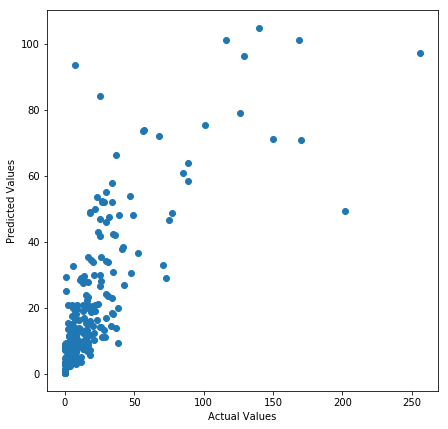

In [107]:
plt.scatter(y3_test, p3)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [108]:
print(m3.score(x3_test, y3_test))

0.5726241587366891


In [109]:
errors = abs(p3 - y3_test)
np.mean(errors)

11.656374999999993

Running our model again with the parameters doesn’t make any difference and we continue to stay in the same range of values for R-squared and average error. Model four explains about 57% of the variance in our data but has an average error of 12 cases. 